# Creating your first CNN

We will create a convolutional neural network to classify hand-written digits. This is a classic example making use of the MNIST dataset, and it is the job that the very first CNN was designed to do.

We will make a simple network with two convolutional layers that will look something like the following:

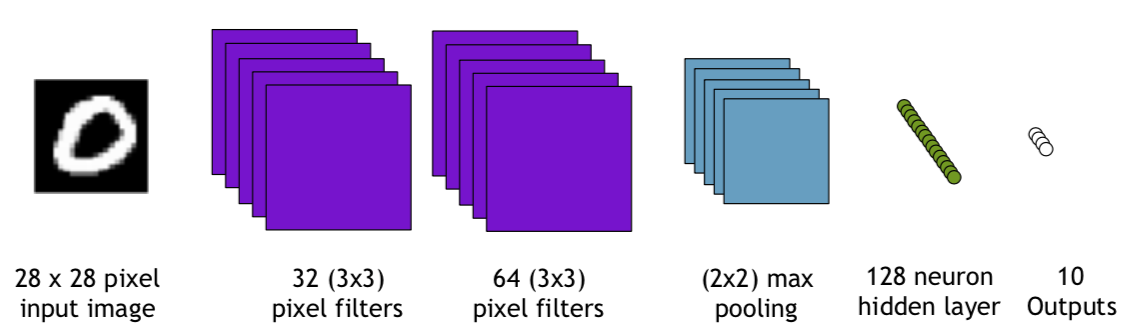



The first step is to include a few libaries that we will make use of. We will be making use of **tensorflow** and **keras** (a higher level much friendlier user interface for tensorflow).

# Some brief notes on the classes we are importing:

`keras.datasets` lets us import the MNIST dataset that we want to use

The import from `keras.model` is a class called `Sequential` and it is a type of neural network model that we can simple add layers to in the order that we require. It is probably the simplest way to build a model.

The imports from `keras.layers` are the types of layers that will be used to build our model. You should recognise these layers from the lecture.
*   `Conv2D`: the layer that performs 2D convolutions
*   `MaxPooling2D`: the pooling layer that downsamples the images
*   `Dense`: the *fully-connected* layer that you see in a standard artificial neural network / multi-layer perceptron
*   `Dropout`: as the name says, performs the dropout - switches off some random fraction fo nodes during training
*   `Flatten`: converts a tensor into a 1D tensor so that we can pass the output of the final 2D convolution into a dense layer.












In [1]:
import tensorflow
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten 
import numpy as np
import matplotlib.pyplot as plot

print('Tensorflow version:',tensorflow.__version__)

Tensorflow version: 2.6.0


Now we can define some variables that will come in useful. Many of these are the network *hyperparameters*.

In [2]:
# The batch size controls the number of images that are processed simultaneously
# It helps with computational efficiency
batch_size = 128
# Since we are classifying hand-written digits, we want to classify each image
# as one of ten values: 0, 1, 2, ... , 8, 9
num_classes = 10
# The number of epochs (iterations over the entire training set) that we want
# to train the network for
epochs = 1
# The learning rate is a very important hyperparameter, as discussed in the
# lecture. This is a fairly common default value to try
learning_rate = 0.001

#MNIST Dataset
The MNIST dataset is a standard dataset and can usefully be accessed directly from `keras`. Let's load the dataset and take a quick look at what we have.

11501568/11490434 [==============================] - 0s 0us/step
Shape of input array = (60000, 28, 28)
Input images have shape 28 x 28
There are 60000 images for training and 10000 images for testing
Example images with true classes [5 0 4 1 9]


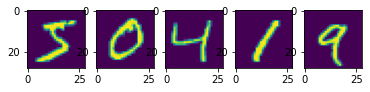

In [3]:
# Since MNIST is a standard dataset, we can just get it straight from keras.
# It is also split between train and test sets automatically
# - x_train is a numpy array that stores the training images
# - y_train is a numpy array that stores the true class of the training images
# - x_train is a numpy array that stores the testing images
# - y_train is a numpy array that stores the true class of the testing images
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Let's store the shape of the images for convenience
print("Shape of input array =",x_train.shape)
training_size = x_train.shape[0]
testing_size = x_test.shape[0]
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
print('Input images have shape',img_rows,'x',img_cols)
print('There are',training_size,'images for training and',testing_size,'images for testing')

# Let's take a look at a few example images from the training set
n_plots=5
print('Example images with true classes',y_train[0:n_plots])
fig, ax = plot.subplots(1, n_plots)
for plot_number in range (0,n_plots):
  ax[plot_number].imshow(x_train[plot_number])


#Data Preparation
Now we want to prepare the data and labels for training. This involves ensuring that we have:
*   The image depth as the final index. Image depth means the number of colour channels, and is 1 for MNIST since they are grey-scale images.
*   The true labels are a single number by default, but the loss function needs to have them in so-called *one-hot encoding* format.
*   `y = 2 becomes y = [0,0,1,0,0,0,0,0,0,0]`
*   `y = 8 becomes y = [0,0,0,0,0,0,0,0,1,0]`


In [4]:
# We need to make sure the numpy arrays are in the correct format for the CNN
# These are 4D tensors where the first number is the number of images, the
# following two arguments are the image size, and the final one is the image 
# depth, which for greyscale is 1, and if these were rgb images, it would be 3
x_train = x_train.reshape(training_size,img_rows,img_cols,1)
x_test = x_test.reshape(testing_size,img_rows,img_cols,1)

# The y_train and y_test values we loaded also need to be modified.
# These values store the true classification of the images (0-9) as a single 
# number. We need to convert the single value into an array of length 10
# corresponding to the number of output classes. Thus values of 
# y = 2 becomes y = [0,0,1,0,0,0,0,0,0,0]
# y = 8 becomes y = [0,0,0,0,0,0,0,0,1,0]
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Let's just check the shapes
print('x_train shape =',x_train.shape)
print('y_train shape =',y_train.shape)

x_train shape = (60000, 28, 28, 1)
y_train shape = (60000, 10)


#Creating the Model

Now it is time to actually build the model. We use the sequential model type that allows us to just sequentially add layers to the network using the `model.add()` function. The model class takes care of passing the output of one layer into the input of the next layer. 

As the picture at the top showed, we want to make a network with the following ten layers:

1.   2D convolution with 32 filters of size 3x3 pixels and stride 1
2.   2D convolution with 64 filters of size 3x3 pixels and stride 1
3.   Max pooling layer to pool regions of 2x2 pixels
4.   Dropout layer to switch off 25% of neurons
5.   Flatten the output into a 1D tensor
6.   Dense layer with 128 neurons
7.   Droput layer to switch off 50% of neurons
8.   Dense layer with 10 neurons for the classification

We will apply the `relu` activation function to the 2D convolutional layers and the first dense layer. The final layer will use a `softmax` activation to ensure the ten output values sum to one. Below are some hints on which functions to make use of - I will only include some of the arguments (the ones that we need here) so please click the links to the documentation if you want to see the full list.

---

[2D Convolution:](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)

`Conv2D(filters=<num_filters>, kernel_size=<filter_size>, strides=<stride>, padding=<padding> activation=<activation_function>)`

*   For the first layer of the network we need to specify the shape of the inputs. For all other layers the `Sequential` class takes care of it all. This means for the first layer we need to include the argument `input_shape=<image_shape>` in the Conv2D function call
*   We will use the default value for padding:  `padding='valid'` so you can omit this from the function call if you wish
*   We will also use the default stride: `strides=(1,1)` 
---
[2D Max Pooling:](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)

`MaxPooling2D(pool_size=<pool_size>, padding=<padding>)`
*   We want to pool pixels within a 2x2 block: `pool_size=(2,2)`
*   As with the convolutions, we want to use `valid` padding (the default value here again)

---
[Dropout:](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)

`Dropout(rate=<rate>)`
*   `rate` is the fraction of neurons to switch off

---
[Flatten:](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)

`Flatten()`

---

[Dense:](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

`Dense(units=<number_of_neurons>, activation=<activation_function>)`
*    The number of neurons is given by `units`
*    Use `relu` as the activation for the first dense layer, and `softmax` for the second
---

In [5]:
# Now we get to define our neural network
model = Sequential()
# The first convolutional layer needs to know what size images it will operate
# on, as given by the input_shape variable. Here we apply a vector of 32 
# filters of size (3,3) pixels. The 'relu' function provides some non-
# linearity, feel free to read up on other activation functions
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(img_rows,img_cols,1)))
# Now we apply a second convolutional layer, this time with 64 (3,3) filters
model.add(Conv2D(64, (3, 3), activation='relu'))
# Pooling layers downsample the images - in this case 2x2 pixels become 
# one pixel
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout disables some of the neurons to prevent overtraining
model.add(Dropout(0.25))
# We flatten the images into a single vector to pass into the dense
# layers
model.add(Flatten())
# The dense layer is what you have seen from a standard neural network
model.add(Dense(128, activation='relu'))
# More dropout to avoid overtraining
model.add(Dropout(0.5))
# The final layer is a dense layer containing (num_classes) nodes.
# Softmax ensures that the sum of these 10 outputs is 1. 
model.add(Dense(num_classes, activation='softmax'))
# Let's have a look at our model to check it has come together as we expect
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

Now we need to choose the loss function and the optimiser and compile the network so that it is ready to use.

The loss function to use for classification tasks is called *categorial cross-entropy*. Note that if you only have two output choices (instead of the 10 we have hear), the simplified *binary-cross-entropy* loss function is the one to use.
*   `keras` provides this for us: `keras.losses.categorical_crossentropy`

There are a number of optimisers that we can use. In this case I have chosen to use Adam.
*    `keras` provides the implementation: `keras.optimizers.Adam(lr=learning_rate)`
*    There are other parameters that can be set, but I just show the learning rate here.

In [ ]:
# Now we build the model, defining the loss function,
# optimiser (I typically use Adam) 
# Learning rate(lr) is a parameter that we can optimise to help
# convergence. We also use cross entropy loss, which is the one
# to use for a classification task with more than two classes.
loss_function = keras.losses.categorical_crossentropy
optimiser = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss=loss_function, optimizer=optimiser, metrics=['accuracy'])

# Train the model using the training data with the true target outputs
model.fit(x_train, y_train,
          batch_size = batch_size,
          epochs = epochs,
          verbose = 1,
          validation_data = (x_test, y_test))

# Run the network on the test sample and see how we do
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/5
469/469 [==============================] - 145s 307ms/step - loss: 0.9222 - accuracy: 0.8742 - val_loss: 0.0732 - val_accuracy: 0.9761
Epoch 2/5
469/469 [==============================] - 142s 303ms/step - loss: 0.1535 - accuracy: 0.9562 - val_loss: 0.0559 - val_accuracy: 0.9819
Epoch 3/5
469/469 [==============================] - 141s 300ms/step - loss: 0.1147 - accuracy: 0.9663 - val_loss: 0.0587 - val_accuracy: 0.9819
Epoch 4/5
155/469 [========>.....................] - ETA: 1:32 - loss: 0.0956 - accuracy: 0.9702

Now let's have a look to see if we can find an image that was incorrectly classified

In [7]:
# Make a list of incorrect classifications
incorrect_indices = []
for i in range(0,testing_size):
  # Note the reshape here that we can use to prevent losing a dimension when
  # choosing a specific element of the array
  prediction = np.argmax(model.predict(x_test[i].reshape(1,28,28,1)))
  truth = np.argmax(y_test[i])
  if prediction != truth:
    incorrect_indices.append([i,prediction,truth])
print('Number of images that were incorrectly classified =',len(incorrect_indices))

Number of images that were incorrectly classified = 137


Incorrect classification for image [95, 6, 4] : predicted = 6 with true = 4


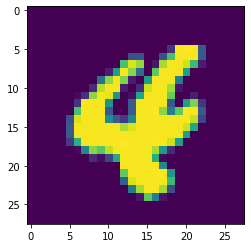

In [8]:
# Now you can modify this part to draw different images from the failures list
# The reshape just removes the depth dimension for drawing
im = 1
image_to_plot = x_test[incorrect_indices[im][0]].reshape(28,28)
fig, ax = plot.subplots(1, 1)
print('Incorrect classification for image',incorrect_indices[im],
      ': predicted =',incorrect_indices[im][1],
      'with true =',incorrect_indices[im][2])
ax.imshow(image_to_plot.reshape((28,28)))